## Details

#### Name: Akshat Toolaj Sinha
#### Entry Number: 2020CSB1068
#### Equity: Tech Mahindra

## Libraries & Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import yfinance as yf
import datetime
import os
import matplotlib.dates as mdates
from arch import arch_model
from scipy.stats import norm

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette('flare')
sns.set_style("darkgrid")
sns.despine()


<Figure size 1200x800 with 0 Axes>

In [3]:
TICKER='TECHM.NS'
PERIOD='max'
FILE_NAME='TECH_MAHINDRA.csv'
PRICE_ANALYSIS='Close'
EQUITY_NAME='Tech Mahindra'
SIGNIFICANCE_LEVEL=0.05
TRADING_DAYS=252
YEAR_DAYS=365
OPTION_EXPIRY=datetime.date(2024,5,31)
TODAY=datetime.date.today()

# Risk Free Rate for 91 Days
RISK_FREE_RATE= 6.88

## Data Downloading & Augmentation

In [4]:
Equity_df=yf.download(TICKER,period=PERIOD,auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [5]:
Equity_df.reset_index(inplace=True)
Equity_df = Equity_df.round(4)

In [6]:
Equity_df.to_csv(FILE_NAME,index=False)

## Data Visualization

Plotting Equity price 

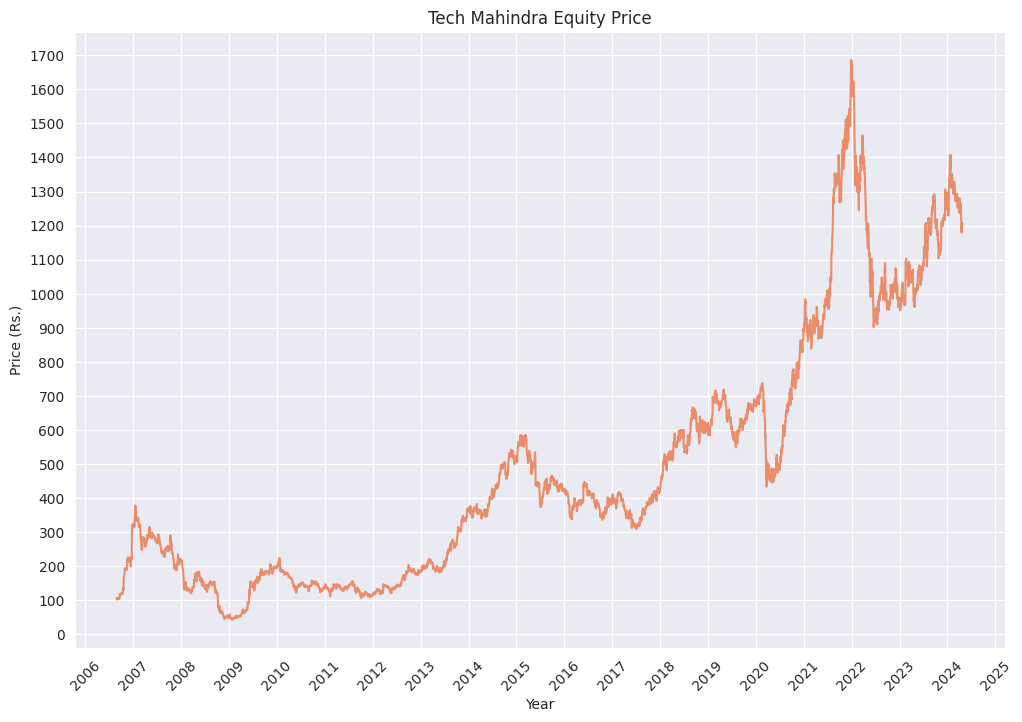

In [7]:
sns.lineplot(data=Equity_df,x='Date',y=PRICE_ANALYSIS)
plt.xlabel("Year")
plt.ylabel("Price (Rs.)")
plt.title(EQUITY_NAME+ " Equity Price")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(range(0,int(max(Equity_df[PRICE_ANALYSIS]))+100,100))
plt.show()

Plotting Log Returns

In [8]:
log_returns=np.log(Equity_df[PRICE_ANALYSIS]/Equity_df[PRICE_ANALYSIS].shift(1))

In [9]:
log_returns=log_returns.dropna()
log_returns.reset_index(drop=True,inplace=True)

In [10]:
log_returns=log_returns*100

In [11]:
dates=Equity_df['Date'][1:]

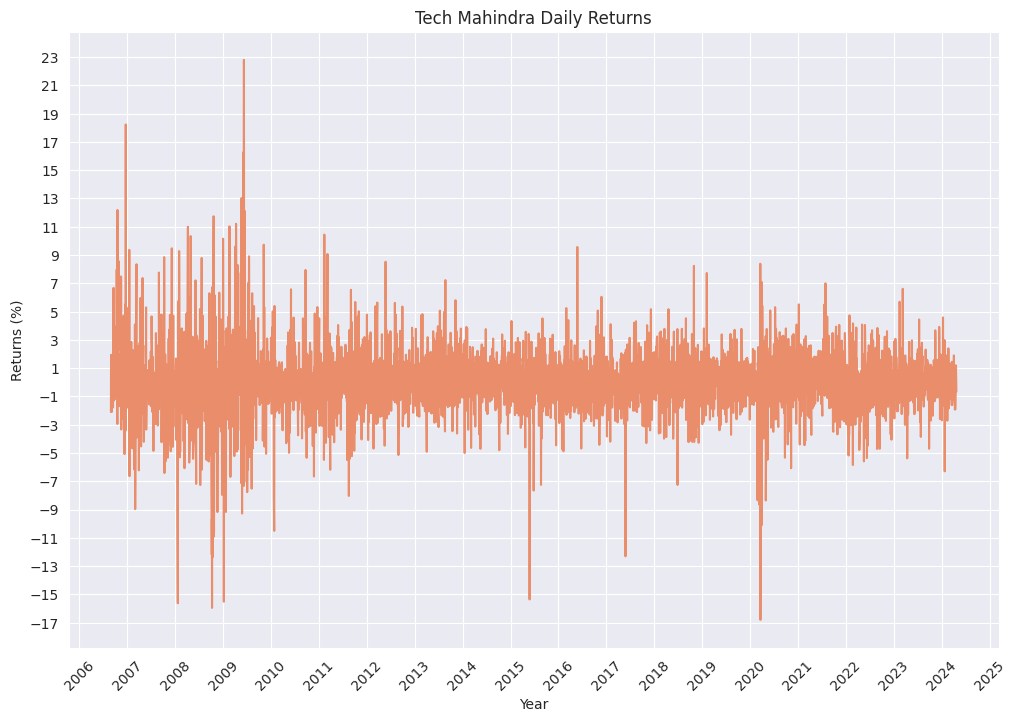

In [12]:
sns.lineplot(x=dates,y=log_returns)
plt.xlabel("Year")
plt.ylabel("Returns (%)")
plt.title(EQUITY_NAME+" Daily Returns")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(np.arange(int(min(log_returns))-1,max(log_returns)+1,2))
plt.show()

## Normality Tests

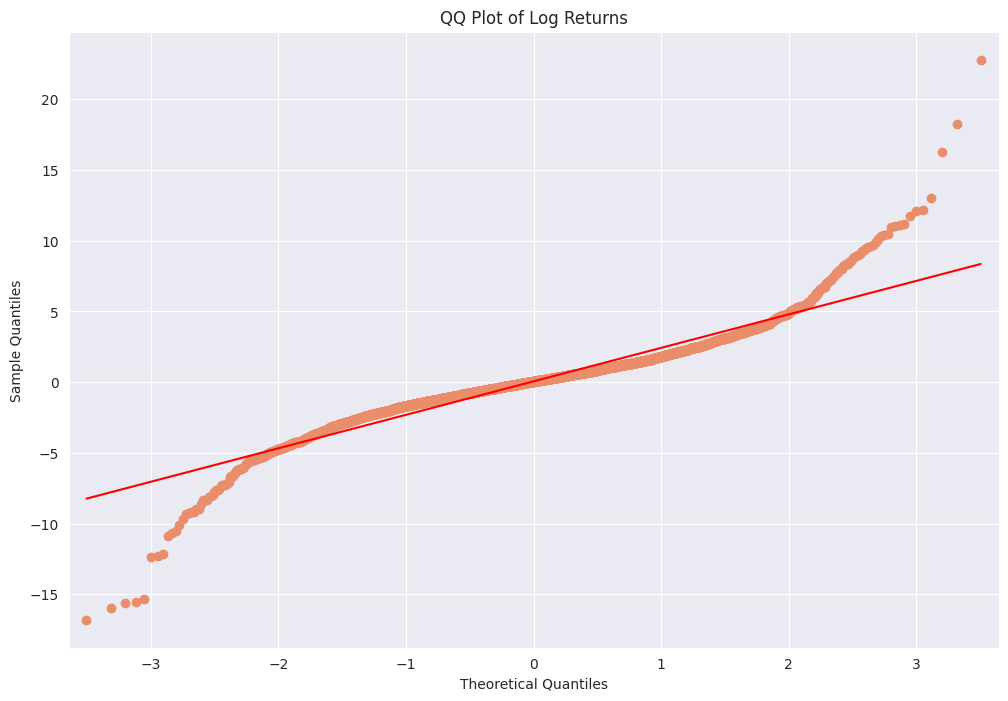

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(log_returns,line='s')
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

<AxesSubplot:xlabel='Close', ylabel='Count'>

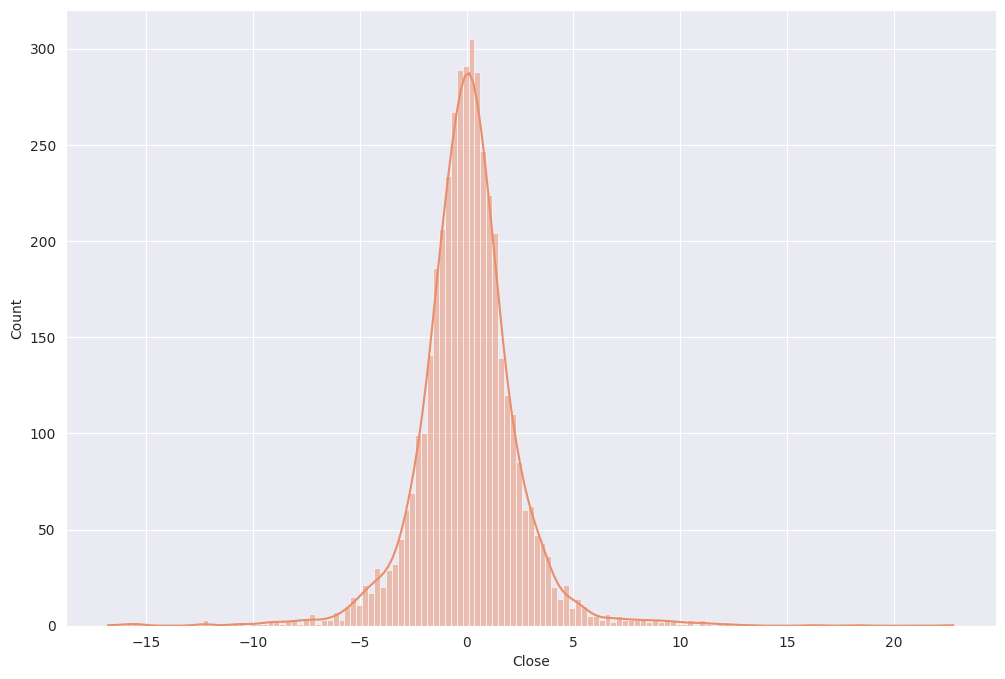

In [14]:
sns.histplot(log_returns,kde=True)

In [15]:
print("Mean of Log Returns: ",round(log_returns.mean(),4))
print("Standard Deviation of Log Returns: ",round(log_returns.std(),4))
print("Skewness of Log Returns: ",round(log_returns.skew(),4))
print("Kurtosis of Log Returns: ",round(log_returns.kurtosis(),4))

Mean of Log Returns:  0.0559
Standard Deviation of Log Returns:  2.3689
Skewness of Log Returns:  0.2003
Kurtosis of Log Returns:  8.6198


In [16]:
# Jarque-Bera Test
from scipy.stats import jarque_bera


jb_test=jarque_bera(log_returns)
print("Jarque-Bera Test Statistic: ",jb_test[0])
print("Jarque-Bera Test P-Value: ",jb_test[1])

if jb_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")

Jarque-Bera Test Statistic:  13464.135706335606
Jarque-Bera Test P-Value:  0.0

Reject Null Hypothesis: The data is not normally distributed


In [17]:
# use Kolmogorov-Smirnov test to check normality

from scipy.stats import kstest

ks_test=kstest(log_returns,'norm')

print("\nKolmogorov-Smirnov Test Statistic: ",ks_test.statistic)
print("Kolmogorov-Smirnov Test P-Value: ",ks_test.pvalue)

if ks_test.pvalue<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Kolmogorov-Smirnov Test Statistic:  0.13096383105164566
Kolmogorov-Smirnov Test P-Value:  1.5752090362949865e-65

Reject Null Hypothesis: The data is not normally distributed


In [18]:
# use Shapiro-Wilk test to check normality

from scipy.stats import shapiro

shapiro_test=shapiro(log_returns)

print("\nShapiro-Wilk Test Statistic: ",shapiro_test[0])
print("Shapiro-Wilk Test P-Value: ",shapiro_test[1])

if shapiro_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Shapiro-Wilk Test Statistic:  0.9122045636177063
Shapiro-Wilk Test P-Value:  1.1210387714598537e-44

Reject Null Hypothesis: The data is not normally distributed


## Returns Analysis

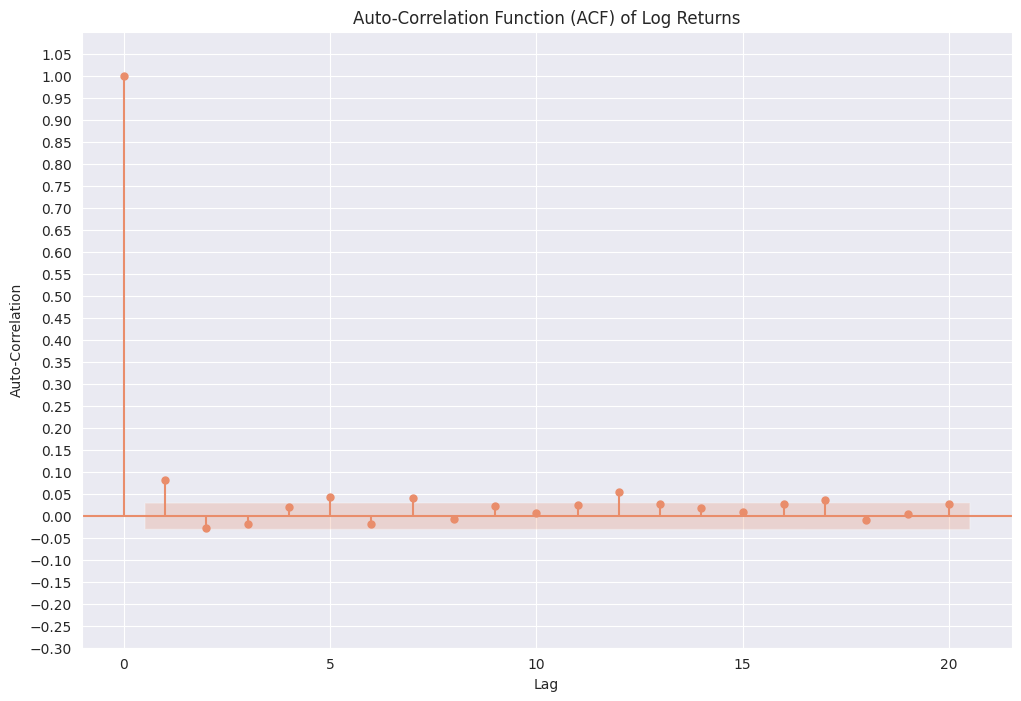

In [19]:
# Check for auto correlation in log_returns

import statsmodels.api as sm

sm.graphics.tsa.plot_acf(log_returns,lags=20)
plt.xlabel('Lag')
plt.ylabel("Auto-Correlation")
plt.title("Auto-Correlation Function (ACF) of Log Returns")
plt.ylim(-0.3,1.1)
plt.yticks(np.arange(-0.3,1.1,0.05))
plt.show()



## Volatility Modelling

In [20]:
HistoricalVolatility=np.std(log_returns)
AnnualHistoricalVolatility=HistoricalVolatility*math.sqrt(TRADING_DAYS)
print("\nHistorical Daily Volatility (%): ",HistoricalVolatility)
print("Historical Annual Volatility (%): ",AnnualHistoricalVolatility)


Historical Daily Volatility (%):  2.368654434694717
Historical Annual Volatility (%):  37.601223456315026


In [21]:
CandidateModels=[(1,1),(1,2),(2,1),(2,2),(3,2),(2,3),(3,3)]

BestModel=None
BestModelStatistic= float('-inf')
Parameters=None

for p,q in CandidateModels:
    model=arch_model(log_returns,vol='Garch',p=p,q=q)
    model_fit=model.fit(disp='off')
    if model_fit.aic>BestModelStatistic:
        BestModelStatistic=model_fit.aic
        BestModel=model_fit
        Parameters=(p,q)

print("\nBest Parameters(p,q): ",Parameters)

GARCHVolatility=BestModel.forecast(horizon=1).variance.iloc[-1].values[-1]
AnnualGARCHVolatility=GARCHVolatility*math.sqrt(TRADING_DAYS)

print("\nGARCH Daily Volatility (%): ",GARCHVolatility)
print("GARCH Annual Volatility (%): ",AnnualGARCHVolatility)


Best Parameters(p,q):  (2, 1)

GARCH Daily Volatility (%):  2.756881471332457
GARCH Annual Volatility (%):  43.76413660336515


## Option Pricing

In [22]:
def nCr(n,r):
    f = math.factorial
    return f(n)/(f(r)*f(n-r))

In [23]:
from abc import ABC,abstractmethod

class OptionPricing(ABC):

    @abstractmethod
    def __init__(self,spot_price,strike_price,risk_free_rate,volatility,time_to_expiry):
        pass

    @abstractmethod
    def OptionPrice(self,type):
        pass

    @abstractmethod
    def setStrikePrice(self,strikePrice):
        pass


In [31]:
class OptionPricingCRR(OptionPricing):

    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0):
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield

        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate

        self.delta=self.YearMaturity/self.steps
        self.u=math.exp(self.volatility*math.sqrt(self.delta))
        self.d=1/self.u
        
        self.riskNeutralProbability=(math.exp((self.riskFreeRate-self.dividentYield)*self.delta)-self.d)/(self.u-self.d)

    def OptionPrice(self,type='C'):

        FuturePrice=0

        for i in range(0,self.steps+1):
            equityPriceMaturity=self.s0*(self.u**i)*(self.d**(self.steps-i))

            if type=='C':
                profit=max(equityPriceMaturity-self.strikePrice,0)
            else:
                profit=max(self.strikePrice-equityPriceMaturity,0)

            prob=(self.riskNeutralProbability**i)*((1-self.riskNeutralProbability)**(self.steps-i))
            

            FuturePrice+=profit*nCr(self.steps,i)*prob

        discountFactor=math.exp(-self.riskFreeRate*self.delta)

        return FuturePrice*discountFactor
    

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [66]:
class OptionPricingSimulation(OptionPricing):
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0,numSimulations=100000):
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield
        self.YearsMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.dStep=self.YearsMaturity/self.steps

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate
        
        self.numSimulations=numSimulations

    def OptionPrice(self,type='C'):

        totalPayoff=0

        for _ in range(self.numSimulations):

            trendTerm=(self.riskFreeRate-self.dividentYield-0.5*(self.volatility**2))*self.YearsMaturity
            volatilityTerm=self.volatility*math.sqrt(self.YearsMaturity)*np.random.normal()

            equityPrice=self.s0*math.exp(trendTerm+volatilityTerm)

            if type=='C':
                payoff=max(equityPrice-self.strikePrice,0)
            else:
                payoff=max(self.strikePrice-equityPrice,0)

            totalPayoff+=payoff
        
        AveragePayoff=totalPayoff/self.numSimulations

        discountFactor=math.exp(-self.riskFreeRate*self.YearsMaturity)
        
        return AveragePayoff*discountFactor

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice
    

In [26]:
class OptionPricingBS(OptionPricing):

    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,dividentYield=0):
        self.s0=s0
        self.strikePrice=strikePrice
        self.Annualvolatility=Annualvolatility
        self.dividentYield=dividentYield
        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS
        self.riskFreeRate=riskFreeRate

    def OptionPrice(self,type='C'):
        term1=math.log(self.s0/self.strikePrice)
        term2=(self.riskFreeRate-self.dividentYield+0.5*self.Annualvolatility**2)*self.YearMaturity
        denominator=self.Annualvolatility*math.sqrt(self.YearMaturity)

        d1=(term1+term2)/denominator
        d2=d1-self.Annualvolatility*math.sqrt(self.YearMaturity)

        if type=='C':
            part1=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(d1)
            part2=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(d2)
            return part1-part2
        else:
            part1=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(-d2)
            part2=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(-d1)
            return part1-part2
        

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [54]:
CurrentPrice=Equity_df[PRICE_ANALYSIS].iloc[-1]
strikePrice=1180

RiskFreeRate=RISK_FREE_RATE/100
step=100


# Volatility=AnnualHistoricalVolatility/100
Volatility=AnnualGARCHVolatility/100

In [62]:
optionCRR=OptionPricingCRR(CurrentPrice,
                        Volatility,
                        strikePrice,
                        OPTION_EXPIRY,
                        RiskFreeRate,
                        step)

optionCRR.OptionPrice('C')

82.79816367443506

In [67]:
optionSimulation=OptionPricingSimulation(CurrentPrice,
                        Volatility,
                        strikePrice,
                        OPTION_EXPIRY,
                        RiskFreeRate,
                        step)

optionSimulation.OptionPrice('C')

82.50485138148643

In [45]:
optionBS=OptionPricingBS(CurrentPrice,
                        Volatility,
                        strikePrice,
                        OPTION_EXPIRY,
                        RiskFreeRate)

optionBS.OptionPrice('C')

82.06265464401724